# 🔋 Wind Farm + Battery Storage Optimization
## Classical MILP Solver (Phase 1 - Baseline)

This notebook implements the day-ahead stochastic MILP formulation for optimizing a wind farm with battery energy storage system (BESS).

**Problem Overview:**
- 24-hour horizon with hourly time steps
- 13 equally-probable wind forecast scenarios
- Maximize expected portfolio revenue (wind sales + battery arbitrage)

## 1. Setup & Dependencies

In [ ]:
# Install required packages (uncomment if needed)
!pip install pulp pandas numpy matplotlib seaborn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pulp import *
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✅ All dependencies loaded successfully!")

✅ All dependencies loaded successfully!


## 2. Problem Parameters

In [ ]:
# ============================================
# BATTERY PARAMETERS
# ============================================

class BatteryParams:
    """Battery Energy Storage System (BESS) parameters"""
    E_max = 16.0          # Energy capacity [MWh]
    P_ch_max = 5.0        # Max charge power [MW]
    P_dis_max = 4.0       # Max discharge power [MW]
    eta_ch = 0.8          # Charge efficiency
    eta_dis = 1.0         # Discharge efficiency
    N_max = 2             # Max full cycles per day
    e_0 = 0.0             # Initial SOC [MWh]
    e_T = 0.0             # Final SOC [MWh]

    # Derived parameters
    max_discharge_energy = N_max * E_max  # 32 MWh

# Time parameters
T = 24  # Number of hours
S = 13  # Number of scenarios
pi_s = 1.0 / S  # Equal probability for each scenario

# Print parameters
print("="*50)
print("BATTERY PARAMETERS")
print("="*50)
print(f"Energy Capacity (E_max):        {BatteryParams.E_max} MWh")
print(f"Max Charge Power (P_ch_max):    {BatteryParams.P_ch_max} MW")
print(f"Max Discharge Power (P_dis_max):{BatteryParams.P_dis_max} MW")
print(f"Charge Efficiency (η_ch):       {BatteryParams.eta_ch}")
print(f"Discharge Efficiency (η_dis):   {BatteryParams.eta_dis}")
print(f"Max Daily Cycles (N_max):       {BatteryParams.N_max}")
print(f"Max Discharge Energy:           {BatteryParams.max_discharge_energy} MWh")
print(f"Initial SOC (e_0):              {BatteryParams.e_0} MWh")
print(f"Final SOC (e_T):                {BatteryParams.e_T} MWh")
print("="*50)
print(f"Time Horizon: {T} hours")
print(f"Scenarios: {S} (probability each: {pi_s:.4f})")

BATTERY PARAMETERS
Energy Capacity (E_max):        16.0 MWh
Max Charge Power (P_ch_max):    5.0 MW
Max Discharge Power (P_dis_max):4.0 MW
Charge Efficiency (η_ch):       0.8
Discharge Efficiency (η_dis):   1.0
Max Daily Cycles (N_max):       2
Max Discharge Energy:           32.0 MWh
Initial SOC (e_0):              0.0 MWh
Final SOC (e_T):                0.0 MWh
Time Horizon: 24 hours
Scenarios: 13 (probability each: 0.0769)


## 3. Load and Analyze Input Data

In [ ]:
# Load data
# For Colab: upload the file or use a URL
# from google.colab import files
# uploaded = files.upload()

# Load from local file or provide URL
try:
    df = pd.read_csv('input_data.csv')
except FileNotFoundError:
    # If running in Colab, you might need to upload the file first
    print("Please upload 'input_data.csv' or modify the path")
    raise

print("Data loaded successfully!")
print(f"Shape: {df.shape}")
df.head()

Data loaded successfully!
Shape: (24, 15)


,hour,scenario_1,scenario_2,scenario_3,scenario_4,scenario_5,scenario_6,scenario_7,scenario_8,scenario_9,scenario_10,scenario_11,scenario_12,scenario_13,price
0,1,9.7879,11.5034,11.9791,14.1908,12.8853,15.5571,6.6945,2.5541,1.2603,1.0340,1.1279,1.1258,1.1785,88.96
1,2,9.8956,11.5903,12.0019,14.2250,12.7664,15.4913,7.0044,2.7490,1.2407,1.2346,1.2413,1.3511,1.1126,83.82
2,3,9.9362,11.6674,12.0415,14.2240,12.6339,15.3941,7.2759,2.9433,1.3617,1.5136,1.4085,1.6377,1.0718,83.00
3,4,9.9593,11.6214,12.0927,14.1792,12.4775,15.2231,7.5040,3.1699,1.5604,1.8890,1.6405,1.9333,1.0590,82.56
4,5,9.9773,11.4704,12.2061,14.1143,12.3181,14.9783,7.7236,3.4366,1.7483,2.2889,1.8440,2.1095,1.0803,82.82


In [ ]:
# Extract data into convenient structures

# Hours (1-indexed in the problem formulation)
hours = df['hour'].values  # [1, 2, ..., 24]

# Market prices (common across all scenarios)
prices = df['price'].values  # p_t for t in T

# Wind production scenarios
# w[t, s] = wind production at hour t under scenario s
scenario_cols = [f'scenario_{i}' for i in range(1, S+1)]
wind_data = df[scenario_cols].values  # Shape: (24, 13)

print("Data structures created:")
print(f"  - prices: shape {prices.shape}")
print(f"  - wind_data: shape {wind_data.shape}")
print(f"\nPrice range: €{prices.min():.2f} - €{prices.max():.2f}/MWh")
print(f"Wind range: {wind_data.min():.2f} - {wind_data.max():.2f} MWh")

Data structures created:
  - prices: shape (24,)
  - wind_data: shape (24, 13)

Price range: €13.72 - €151.42/MWh
Wind range: 1.03 - 16.37 MWh


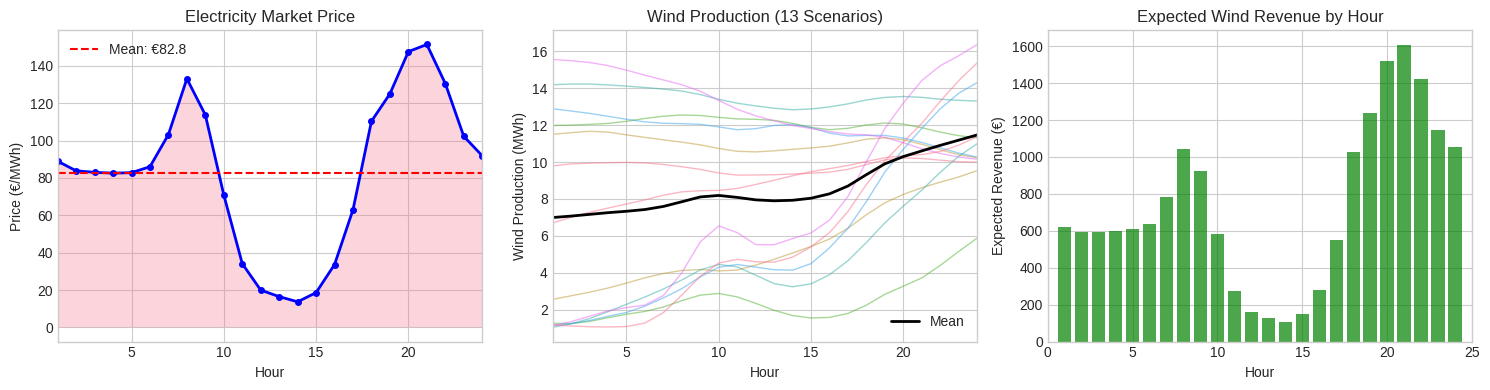


📊 Key Insights:
  - Peak price hours: [21 20  8] (€[151.4 147.6 133.1])
  - Low price hours: [14 13 15] (€[13.7 16.5 18.6])
  - Total expected wind revenue: €17645.48


In [ ]:
# Visualize the input data
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Price profile
ax1 = axes[0]
ax1.plot(hours, prices, 'b-o', linewidth=2, markersize=4)
ax1.fill_between(hours, prices, alpha=0.3)
ax1.set_xlabel('Hour')
ax1.set_ylabel('Price (€/MWh)')
ax1.set_title('Electricity Market Price')
ax1.set_xlim(1, 24)
ax1.axhline(y=prices.mean(), color='r', linestyle='--', label=f'Mean: €{prices.mean():.1f}')
ax1.legend()

# Plot 2: Wind scenarios
ax2 = axes[1]
for s in range(S):
    ax2.plot(hours, wind_data[:, s], alpha=0.5, linewidth=1)
ax2.plot(hours, wind_data.mean(axis=1), 'k-', linewidth=2, label='Mean')
ax2.set_xlabel('Hour')
ax2.set_ylabel('Wind Production (MWh)')
ax2.set_title(f'Wind Production ({S} Scenarios)')
ax2.set_xlim(1, 24)
ax2.legend()

# Plot 3: Expected wind revenue by hour
ax3 = axes[2]
expected_wind = wind_data.mean(axis=1)
expected_revenue = prices * expected_wind
ax3.bar(hours, expected_revenue, color='green', alpha=0.7)
ax3.set_xlabel('Hour')
ax3.set_ylabel('Expected Revenue (€)')
ax3.set_title('Expected Wind Revenue by Hour')
ax3.set_xlim(0, 25)

plt.tight_layout()
plt.show()

print(f"\n📊 Key Insights:")
print(f"  - Peak price hours: {hours[np.argsort(prices)[-3:][::-1]]} (€{np.sort(prices)[-3:][::-1].round(1)})")
print(f"  - Low price hours: {hours[np.argsort(prices)[:3]]} (€{np.sort(prices)[:3].round(1)})")
print(f"  - Total expected wind revenue: €{expected_revenue.sum():.2f}")

## 4. MILP Formulation

### Mathematical Model

**Objective:** Maximize expected portfolio revenue
$$\max \sum_{s \in S} \pi_s \sum_{t \in T} p_t w_{t,s} + \sum_{t \in T} p_t (P^{dis}_t - P^{ch}_t)$$

**Subject to:**

1. **SOC Dynamics:** $e_t = e_{t-1} + \eta^{ch} P^{ch}_t - P^{dis}_t$

2. **SOC Bounds:** $0 \le e_t \le E^{max}$

3. **Power Bounds:** $0 \le P^{ch}_t \le P^{ch,max}$, $0 \le P^{dis}_t \le P^{dis,max}$

4. **Mutual Exclusivity:** $P^{ch}_t \le P^{ch,max} y_t$, $P^{dis}_t \le P^{dis,max}(1-y_t)$

5. **Initial/Final SOC:** $e_0 = 0$, $e_{24} = 0$

6. **Cycling Limit:** $\sum_t P^{dis}_t \le N^{max} E^{max}$

In [ ]:
def solve_battery_milp(prices, wind_data, params=BatteryParams, verbose=True):
    """
    Solve the day-ahead stochastic MILP for wind farm + BESS optimization.

    Parameters:
    -----------
    prices : array (T,)
        Hourly electricity prices [€/MWh]
    wind_data : array (T, S)
        Wind production scenarios [MWh]
    params : class
        Battery parameters
    verbose : bool
        Print solver output

    Returns:
    --------
    dict : Solution dictionary with all variables and objective value
    """

    T = len(prices)
    S = wind_data.shape[1]
    pi_s = 1.0 / S

    # Create the optimization model
    model = LpProblem("Wind_Battery_Optimization", LpMaximize)

    # ============================================
    # DECISION VARIABLES
    # ============================================

    # Time indices (0-indexed for Python, but we use 1-24 in the model)
    time_steps = range(T)

    # Charging power: P_ch[t] >= 0
    P_ch = LpVariable.dicts("P_ch", time_steps, lowBound=0, upBound=params.P_ch_max)

    # Discharging power: P_dis[t] >= 0
    P_dis = LpVariable.dicts("P_dis", time_steps, lowBound=0, upBound=params.P_dis_max)

    # State of charge: e[t] >= 0
    # We define e[t] for t = 0, 1, ..., T where e[0] is initial SOC
    e = LpVariable.dicts("e", range(T+1), lowBound=0, upBound=params.E_max)

    # Binary mode variable: y[t] = 1 if charging, 0 if discharging
    y = LpVariable.dicts("y", time_steps, cat='Binary')

    # ============================================
    # OBJECTIVE FUNCTION
    # ============================================

    # Expected wind revenue (constant, doesn't affect optimization but included for completeness)
    wind_revenue = lpSum(
        pi_s * prices[t] * wind_data[t, s]
        for t in time_steps
        for s in range(S)
    )

    # Battery arbitrage revenue
    battery_revenue = lpSum(
        prices[t] * (P_dis[t] - P_ch[t])
        for t in time_steps
    )

    # Total objective
    model += wind_revenue + battery_revenue, "Total_Expected_Revenue"

    # ============================================
    # CONSTRAINTS
    # ============================================

    # Initial SOC condition: e_0 = 0
    model += e[0] == params.e_0, "Initial_SOC"

    # Final SOC condition: e_24 = 0
    model += e[T] == params.e_T, "Final_SOC"

    # SOC dynamics for each hour
    for t in time_steps:
        # e[t+1] = e[t] + η_ch * P_ch[t] - (1/η_dis) * P_dis[t]
        # With η_dis = 1, this simplifies to:
        # e[t+1] = e[t] + η_ch * P_ch[t] - P_dis[t]
        model += (
            e[t+1] == e[t] + params.eta_ch * P_ch[t] - (1/params.eta_dis) * P_dis[t],
            f"SOC_Dynamics_t{t+1}"
        )

    # Mutual exclusivity constraints
    for t in time_steps:
        # Charging only when y[t] = 1
        model += P_ch[t] <= params.P_ch_max * y[t], f"Charge_Mutex_t{t+1}"

        # Discharging only when y[t] = 0
        model += P_dis[t] <= params.P_dis_max * (1 - y[t]), f"Discharge_Mutex_t{t+1}"

    # Daily cycling limit: total discharge <= N_max * E_max
    model += (
        lpSum(P_dis[t] for t in time_steps) <= params.N_max * params.E_max,
        "Daily_Cycling_Limit"
    )

    # ============================================
    # SOLVE
    # ============================================

    if verbose:
        print("Solving MILP...")

    # Solve with default solver (CBC)
    solver = PULP_CBC_CMD(msg=verbose)
    model.solve(solver)

    # ============================================
    # EXTRACT SOLUTION
    # ============================================

    if LpStatus[model.status] != 'Optimal':
        print(f"⚠️ Solver status: {LpStatus[model.status]}")
        return None

    # Extract variable values
    solution = {
        'status': LpStatus[model.status],
        'objective': value(model.objective),
        'P_ch': np.array([value(P_ch[t]) for t in time_steps]),
        'P_dis': np.array([value(P_dis[t]) for t in time_steps]),
        'e': np.array([value(e[t]) for t in range(T+1)]),
        'y': np.array([value(y[t]) for t in time_steps]),
        'wind_revenue': sum(
            pi_s * prices[t] * wind_data[t, s]
            for t in time_steps
            for s in range(S)
        ),
        'battery_revenue': sum(
            prices[t] * (value(P_dis[t]) - value(P_ch[t]))
            for t in time_steps
        )
    }

    if verbose:
        print(f"\n✅ Optimization Complete!")
        print(f"   Status: {solution['status']}")
        print(f"   Total Revenue: €{solution['objective']:.2f}")
        print(f"   - Wind Revenue: €{solution['wind_revenue']:.2f}")
        print(f"   - Battery Revenue: €{solution['battery_revenue']:.2f}")

    return solution

## 5. Solve the Optimization Problem

In [ ]:
# Solve the MILP
solution = solve_battery_milp(prices, wind_data, BatteryParams, verbose=True)

Solving MILP...

✅ Optimization Complete!
   Status: Optimal
   Total Revenue: €19680.02
   - Wind Revenue: €17645.48
   - Battery Revenue: €2034.54


In [ ]:
# Display detailed solution
if solution:
    print("\n" + "="*60)
    print("OPTIMAL SOLUTION DETAILS")
    print("="*60)

    # Create solution dataframe
    sol_df = pd.DataFrame({
        'Hour': hours,
        'Price (€/MWh)': prices,
        'P_ch (MW)': solution['P_ch'].round(3),
        'P_dis (MW)': solution['P_dis'].round(3),
        'SOC End (MWh)': solution['e'][1:].round(3),
        'Mode (y)': solution['y'].astype(int),
        'Net Power (MW)': (solution['P_dis'] - solution['P_ch']).round(3)
    })

    print(sol_df.to_string(index=False))

    # Summary statistics
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    print(f"Total Energy Charged:     {solution['P_ch'].sum():.2f} MWh")
    print(f"Total Energy Discharged:  {solution['P_dis'].sum():.2f} MWh")
    print(f"Equivalent Cycles:        {solution['P_dis'].sum() / BatteryParams.E_max:.2f}")
    print(f"Max SOC Reached:          {solution['e'].max():.2f} MWh")
    print(f"Charging Hours:           {int(solution['y'].sum())}")
    print(f"Discharging Hours:        {int((1-solution['y']).sum())}")


OPTIMAL SOLUTION DETAILS
 Hour  Price (€/MWh)  P_ch (MW)  P_dis (MW)  SOC End (MWh)  Mode (y)  Net Power (MW)
    1          88.96        0.0         0.0            0.0         1             0.0
    2          83.82        0.0         0.0            0.0         0             0.0
    3          83.00        0.0         0.0            0.0         0             0.0
    4          82.56        5.0         0.0            4.0         1            -5.0
    5          82.82        5.0         0.0            8.0         1            -5.0
    6          86.01        0.0         0.0            8.0         0             0.0
    7         103.21        0.0         0.0            8.0         0             0.0
    8         133.09        0.0         4.0            4.0         0             4.0
    9         113.73        0.0         4.0            0.0         0             4.0
   10          70.89        0.0         0.0            0.0         0             0.0
   11          34.14        0.0        

## 6. Visualize the Solution

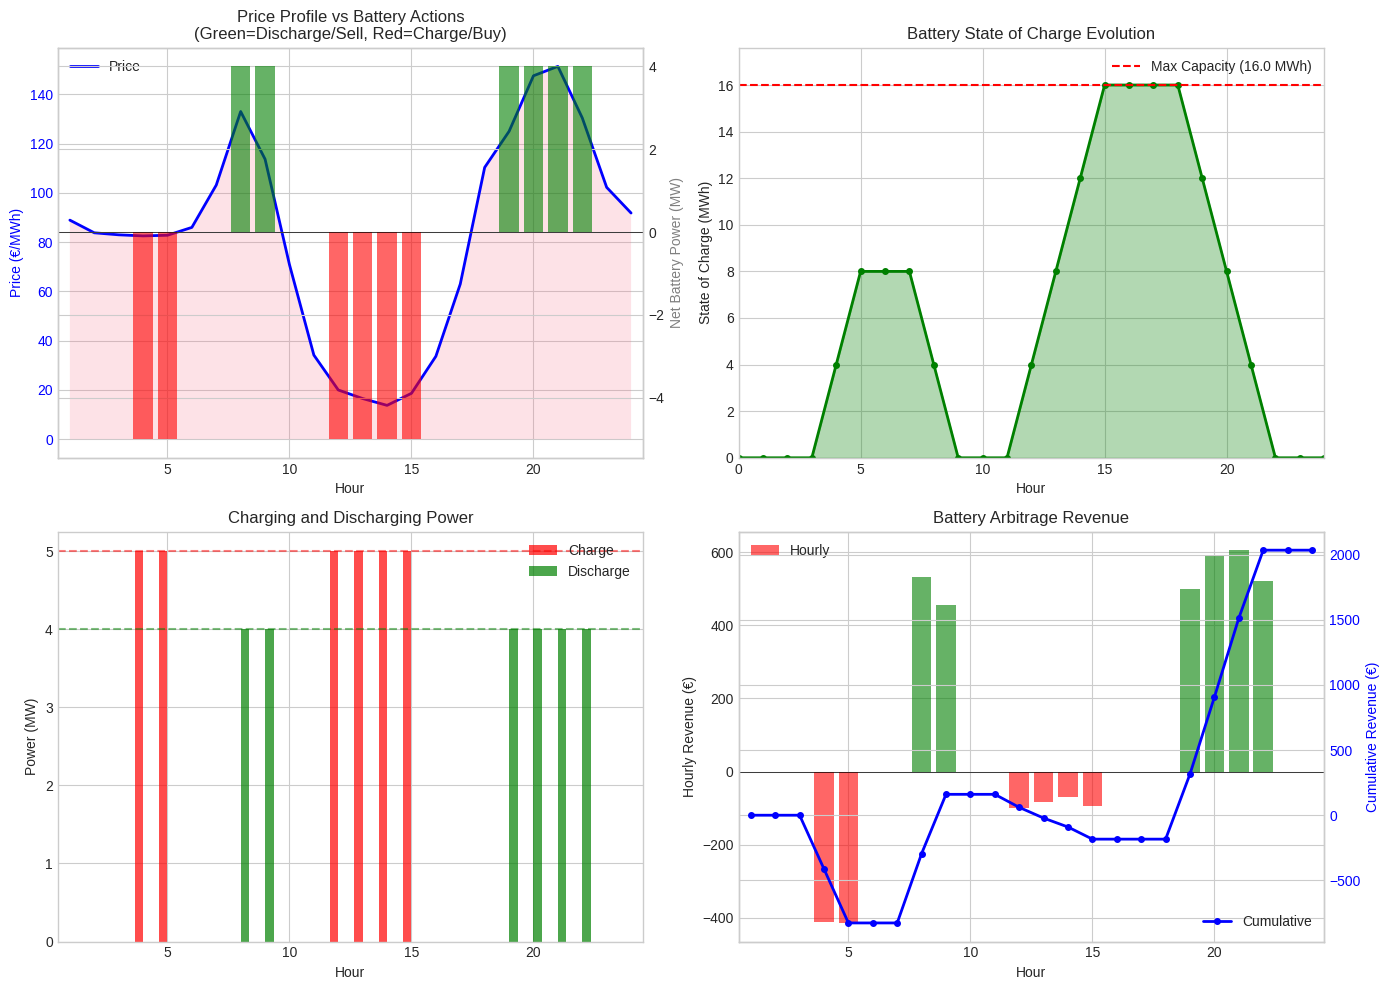

In [ ]:
def plot_solution(solution, prices, hours):
    """Create comprehensive visualization of the optimization solution"""

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Plot 1: Price and Battery Actions
    ax1 = axes[0, 0]
    ax1_twin = ax1.twinx()

    # Price line
    ax1.plot(hours, prices, 'b-', linewidth=2, label='Price')
    ax1.fill_between(hours, prices, alpha=0.2)
    ax1.set_ylabel('Price (€/MWh)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Net battery power (positive = discharge/sell, negative = charge/buy)
    net_power = solution['P_dis'] - solution['P_ch']
    colors = ['green' if p > 0 else 'red' for p in net_power]
    ax1_twin.bar(hours, net_power, color=colors, alpha=0.6, width=0.8)
    ax1_twin.set_ylabel('Net Battery Power (MW)', color='gray')
    ax1_twin.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

    ax1.set_xlabel('Hour')
    ax1.set_title('Price Profile vs Battery Actions\n(Green=Discharge/Sell, Red=Charge/Buy)')
    ax1.set_xlim(0.5, 24.5)
    ax1.legend(loc='upper left')

    # Plot 2: State of Charge Evolution
    ax2 = axes[0, 1]
    soc_hours = list(range(25))  # 0 to 24
    ax2.plot(soc_hours, solution['e'], 'g-o', linewidth=2, markersize=4)
    ax2.fill_between(soc_hours, solution['e'], alpha=0.3, color='green')
    ax2.axhline(y=BatteryParams.E_max, color='red', linestyle='--',
                label=f'Max Capacity ({BatteryParams.E_max} MWh)')
    ax2.set_xlabel('Hour')
    ax2.set_ylabel('State of Charge (MWh)')
    ax2.set_title('Battery State of Charge Evolution')
    ax2.set_xlim(0, 24)
    ax2.set_ylim(0, BatteryParams.E_max * 1.1)
    ax2.legend()

    # Plot 3: Charge and Discharge Power
    ax3 = axes[1, 0]
    width = 0.35
    ax3.bar(hours - width/2, solution['P_ch'], width, label='Charge', color='red', alpha=0.7)
    ax3.bar(hours + width/2, solution['P_dis'], width, label='Discharge', color='green', alpha=0.7)
    ax3.axhline(y=BatteryParams.P_ch_max, color='red', linestyle='--', alpha=0.5)
    ax3.axhline(y=BatteryParams.P_dis_max, color='green', linestyle='--', alpha=0.5)
    ax3.set_xlabel('Hour')
    ax3.set_ylabel('Power (MW)')
    ax3.set_title('Charging and Discharging Power')
    ax3.set_xlim(0.5, 24.5)
    ax3.legend()

    # Plot 4: Cumulative Revenue
    ax4 = axes[1, 1]
    hourly_battery_rev = prices * (solution['P_dis'] - solution['P_ch'])
    cumulative_rev = np.cumsum(hourly_battery_rev)

    # Bar chart for hourly revenue
    colors = ['green' if r > 0 else 'red' for r in hourly_battery_rev]
    ax4.bar(hours, hourly_battery_rev, color=colors, alpha=0.6, label='Hourly')

    # Line for cumulative
    ax4_twin = ax4.twinx()
    ax4_twin.plot(hours, cumulative_rev, 'b-o', linewidth=2, markersize=4, label='Cumulative')
    ax4_twin.set_ylabel('Cumulative Revenue (€)', color='blue')
    ax4_twin.tick_params(axis='y', labelcolor='blue')

    ax4.set_xlabel('Hour')
    ax4.set_ylabel('Hourly Revenue (€)')
    ax4.set_title('Battery Arbitrage Revenue')
    ax4.set_xlim(0.5, 24.5)
    ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax4.legend(loc='upper left')
    ax4_twin.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

# Plot the solution
if solution:
    plot_solution(solution, prices, hours)

## 7. Constraint Verification

In [ ]:
def verify_constraints(solution, params=BatteryParams):
    """Verify all constraints are satisfied"""

    print("\n" + "="*60)
    print("CONSTRAINT VERIFICATION")
    print("="*60)

    all_satisfied = True
    tolerance = 1e-6

    # 1. SOC Bounds
    soc_min = solution['e'].min()
    soc_max = solution['e'].max()
    soc_ok = (soc_min >= -tolerance) and (soc_max <= params.E_max + tolerance)
    print(f"\n1. SOC Bounds (0 ≤ e ≤ {params.E_max}):")
    print(f"   Min SOC: {soc_min:.4f}, Max SOC: {soc_max:.4f}")
    print(f"   Status: {'✅ SATISFIED' if soc_ok else '❌ VIOLATED'}")
    all_satisfied &= soc_ok

    # 2. Power Bounds
    pch_ok = (solution['P_ch'].min() >= -tolerance) and (solution['P_ch'].max() <= params.P_ch_max + tolerance)
    pdis_ok = (solution['P_dis'].min() >= -tolerance) and (solution['P_dis'].max() <= params.P_dis_max + tolerance)
    print(f"\n2. Power Bounds:")
    print(f"   P_ch range: [{solution['P_ch'].min():.4f}, {solution['P_ch'].max():.4f}] (max: {params.P_ch_max})")
    print(f"   P_dis range: [{solution['P_dis'].min():.4f}, {solution['P_dis'].max():.4f}] (max: {params.P_dis_max})")
    print(f"   Status: {'✅ SATISFIED' if (pch_ok and pdis_ok) else '❌ VIOLATED'}")
    all_satisfied &= pch_ok and pdis_ok

    # 3. Initial/Final SOC
    init_ok = abs(solution['e'][0] - params.e_0) < tolerance
    final_ok = abs(solution['e'][-1] - params.e_T) < tolerance
    print(f"\n3. Initial/Final SOC:")
    print(f"   e_0 = {solution['e'][0]:.4f} (should be {params.e_0})")
    print(f"   e_24 = {solution['e'][-1]:.4f} (should be {params.e_T})")
    print(f"   Status: {'✅ SATISFIED' if (init_ok and final_ok) else '❌ VIOLATED'}")
    all_satisfied &= init_ok and final_ok

    # 4. SOC Dynamics
    dynamics_errors = []
    for t in range(len(solution['P_ch'])):
        expected = solution['e'][t] + params.eta_ch * solution['P_ch'][t] - solution['P_dis'][t]
        actual = solution['e'][t+1]
        error = abs(expected - actual)
        if error > tolerance:
            dynamics_errors.append((t+1, error))
    dynamics_ok = len(dynamics_errors) == 0
    print(f"\n4. SOC Dynamics:")
    print(f"   e[t+1] = e[t] + η_ch*P_ch[t] - P_dis[t]")
    print(f"   Status: {'✅ SATISFIED' if dynamics_ok else '❌ VIOLATED at hours ' + str([e[0] for e in dynamics_errors])}")
    all_satisfied &= dynamics_ok

    # 5. Mutual Exclusivity
    mutex_violations = []
    for t in range(len(solution['P_ch'])):
        if solution['P_ch'][t] > tolerance and solution['P_dis'][t] > tolerance:
            mutex_violations.append(t+1)
    mutex_ok = len(mutex_violations) == 0
    print(f"\n5. Mutual Exclusivity (no simultaneous charge/discharge):")
    print(f"   Status: {'✅ SATISFIED' if mutex_ok else '❌ VIOLATED at hours ' + str(mutex_violations)}")
    all_satisfied &= mutex_ok

    # 6. Cycling Limit
    total_discharge = solution['P_dis'].sum()
    max_discharge = params.N_max * params.E_max
    cycling_ok = total_discharge <= max_discharge + tolerance
    print(f"\n6. Cycling Limit:")
    print(f"   Total Discharge: {total_discharge:.4f} MWh (max: {max_discharge} MWh)")
    print(f"   Equivalent Cycles: {total_discharge/params.E_max:.2f} (max: {params.N_max})")
    print(f"   Status: {'✅ SATISFIED' if cycling_ok else '❌ VIOLATED'}")
    all_satisfied &= cycling_ok

    print("\n" + "="*60)
    print(f"OVERALL: {'✅ ALL CONSTRAINTS SATISFIED' if all_satisfied else '❌ SOME CONSTRAINTS VIOLATED'}")
    print("="*60)

    return all_satisfied

# Verify constraints
if solution:
    verify_constraints(solution)


CONSTRAINT VERIFICATION

1. SOC Bounds (0 ≤ e ≤ 16.0):
   Min SOC: 0.0000, Max SOC: 16.0000
   Status: ✅ SATISFIED

2. Power Bounds:
   P_ch range: [0.0000, 5.0000] (max: 5.0)
   P_dis range: [0.0000, 4.0000] (max: 4.0)
   Status: ✅ SATISFIED

3. Initial/Final SOC:
   e_0 = 0.0000 (should be 0.0)
   e_24 = 0.0000 (should be 0.0)
   Status: ✅ SATISFIED

4. SOC Dynamics:
   e[t+1] = e[t] + η_ch*P_ch[t] - P_dis[t]
   Status: ✅ SATISFIED

5. Mutual Exclusivity (no simultaneous charge/discharge):
   Status: ✅ SATISFIED

6. Cycling Limit:
   Total Discharge: 24.0000 MWh (max: 32.0 MWh)
   Equivalent Cycles: 1.50 (max: 2)
   Status: ✅ SATISFIED

OVERALL: ✅ ALL CONSTRAINTS SATISFIED


## 8. Scenario Analysis


SCENARIO ANALYSIS
 Scenario  Wind Revenue  Battery Revenue  Total Revenue
        1      19651.56          2034.54       21686.10
        2      21998.61          2034.54       24033.15
        3      23942.53          2034.54       25977.07
        4      27116.03          2034.54       29150.57
        5      23217.50          2034.54       25252.04
        6      25298.86          2034.54       27333.40
        7      18143.25          2034.54       20177.79
        8      11629.82          2034.54       13664.36
        9       5515.79          2034.54        7550.33
       10      10464.77          2034.54       12499.31
       11      13071.02          2034.54       15105.56
       12      15970.76          2034.54       18005.30
       13      13370.69          2034.54       15405.23

------------------------------------------------------------
STATISTICS
------------------------------------------------------------
Expected Total Revenue: €19680.02
Best Scenario (#4): €29150.57

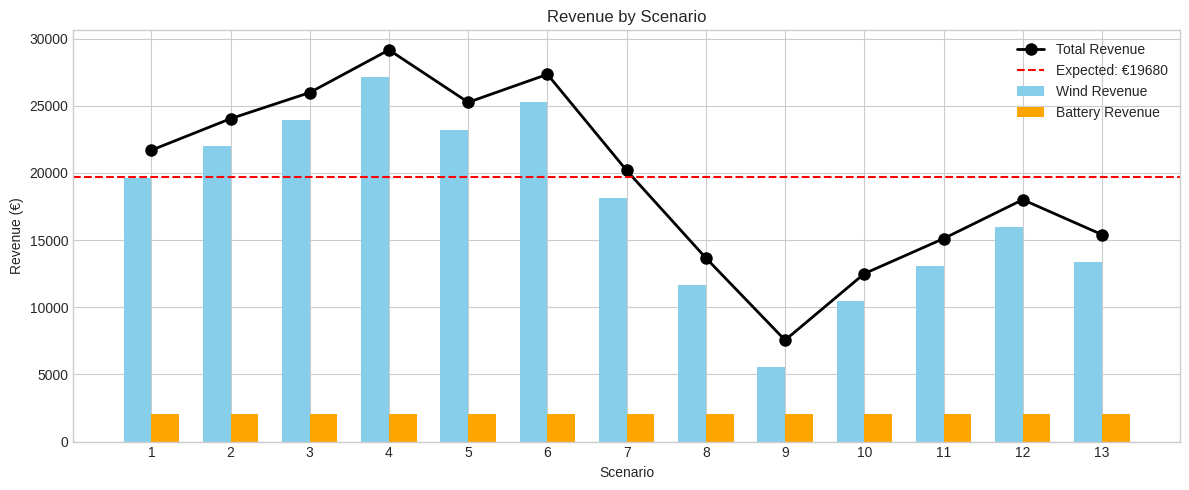

In [ ]:
def analyze_scenarios(solution, prices, wind_data):
    """Analyze revenue across different wind scenarios"""

    T = len(prices)
    S = wind_data.shape[1]

    # Calculate revenue for each scenario
    scenario_revenues = []

    for s in range(S):
        wind_rev = sum(prices[t] * wind_data[t, s] for t in range(T))
        battery_rev = sum(prices[t] * (solution['P_dis'][t] - solution['P_ch'][t]) for t in range(T))
        total_rev = wind_rev + battery_rev
        scenario_revenues.append({
            'Scenario': s + 1,
            'Wind Revenue': wind_rev,
            'Battery Revenue': battery_rev,
            'Total Revenue': total_rev
        })

    scenario_df = pd.DataFrame(scenario_revenues)

    print("\n" + "="*60)
    print("SCENARIO ANALYSIS")
    print("="*60)
    print(scenario_df.round(2).to_string(index=False))

    print("\n" + "-"*60)
    print("STATISTICS")
    print("-"*60)
    print(f"Expected Total Revenue: €{scenario_df['Total Revenue'].mean():.2f}")
    print(f"Best Scenario (#{scenario_df['Total Revenue'].idxmax()+1}): €{scenario_df['Total Revenue'].max():.2f}")
    print(f"Worst Scenario (#{scenario_df['Total Revenue'].idxmin()+1}): €{scenario_df['Total Revenue'].min():.2f}")
    print(f"Standard Deviation: €{scenario_df['Total Revenue'].std():.2f}")
    print(f"Revenue Range: €{scenario_df['Total Revenue'].max() - scenario_df['Total Revenue'].min():.2f}")

    # Plot scenario comparison
    fig, ax = plt.subplots(figsize=(12, 5))

    x = scenario_df['Scenario']
    width = 0.35

    ax.bar(x - width/2, scenario_df['Wind Revenue'], width, label='Wind Revenue', color='skyblue')
    ax.bar(x + width/2, scenario_df['Battery Revenue'], width, label='Battery Revenue', color='orange')
    ax.plot(x, scenario_df['Total Revenue'], 'ko-', markersize=8, linewidth=2, label='Total Revenue')

    ax.axhline(y=scenario_df['Total Revenue'].mean(), color='red', linestyle='--',
               label=f"Expected: €{scenario_df['Total Revenue'].mean():.0f}")

    ax.set_xlabel('Scenario')
    ax.set_ylabel('Revenue (€)')
    ax.set_title('Revenue by Scenario')
    ax.legend(loc='upper right')
    ax.set_xticks(x)

    plt.tight_layout()
    plt.show()

    return scenario_df

# Analyze scenarios
if solution:
    scenario_df = analyze_scenarios(solution, prices, wind_data)

## 9. Export Solution for Quantum Phase

In [ ]:
def export_solution(solution, prices, wind_data, filename='classical_solution.npz'):
    """Export solution data for use in quantum optimization phase"""

    np.savez(filename,
        # Solution variables
        P_ch=solution['P_ch'],
        P_dis=solution['P_dis'],
        e=solution['e'],
        y=solution['y'],

        # Objective values
        objective=solution['objective'],
        wind_revenue=solution['wind_revenue'],
        battery_revenue=solution['battery_revenue'],

        # Input data
        prices=prices,
        wind_data=wind_data,

        # Parameters
        E_max=BatteryParams.E_max,
        P_ch_max=BatteryParams.P_ch_max,
        P_dis_max=BatteryParams.P_dis_max,
        eta_ch=BatteryParams.eta_ch,
        eta_dis=BatteryParams.eta_dis,
        N_max=BatteryParams.N_max
    )

    print(f"\n✅ Solution exported to '{filename}'")
    print("   This file contains all data needed for the quantum optimization phase.")

# Export solution
if solution:
    export_solution(solution, prices, wind_data)


✅ Solution exported to 'classical_solution.npz'
   This file contains all data needed for the quantum optimization phase.


## 10. Summary & Key Insights for Quantum Phase

In [ ]:
if solution:
    print("\n" + "="*70)
    print("📊 PHASE 1 SUMMARY: CLASSICAL MILP BASELINE")
    print("="*70)

    print("\n🎯 OPTIMAL SOLUTION:")
    print(f"   Total Expected Revenue: €{solution['objective']:.2f}")
    print(f"   - Wind Revenue:         €{solution['wind_revenue']:.2f} (fixed)")
    print(f"   - Battery Arbitrage:    €{solution['battery_revenue']:.2f}")

    print("\n🔋 BATTERY OPERATION:")
    print(f"   Charging Hours:    {int(solution['y'].sum())} hours")
    print(f"   Discharging Hours: {int((1-solution['y']).sum())} hours")
    print(f"   Total Charged:     {solution['P_ch'].sum():.2f} MWh")
    print(f"   Total Discharged:  {solution['P_dis'].sum():.2f} MWh")
    print(f"   Cycles Used:       {solution['P_dis'].sum()/BatteryParams.E_max:.2f} / {BatteryParams.N_max}")

    print("\n💡 KEY INSIGHTS FOR QUANTUM PHASE:")
    print(f"   1. Binary variables (y_t): {int(solution['y'].sum())} hours charging, {24-int(solution['y'].sum())} discharging")
    print(f"   2. Mode pattern: {['C' if y==1 else 'D' for y in solution['y']]}")
    print(f"   3. Critical constraint: Cycling limit is {'binding' if abs(solution['P_dis'].sum() - 32) < 0.1 else 'not binding'}")

    # Identify key hours
    charge_hours = np.where(solution['y'] == 1)[0] + 1
    discharge_hours = np.where(solution['y'] == 0)[0] + 1

    print(f"\n   4. Charging hours (low price):    {list(charge_hours)}")
    print(f"   5. Discharging hours (high price): {list(discharge_hours)}")

    print("\n" + "="*70)
    print("✅ Phase 1 Complete! Ready for Phase 2: QUBO Formulation")
    print("="*70)


📊 PHASE 1 SUMMARY: CLASSICAL MILP BASELINE

🎯 OPTIMAL SOLUTION:
   Total Expected Revenue: €19680.02
   - Wind Revenue:         €17645.48 (fixed)
   - Battery Arbitrage:    €2034.54

🔋 BATTERY OPERATION:
   Charging Hours:    7 hours
   Discharging Hours: 17 hours
   Total Charged:     30.00 MWh
   Total Discharged:  24.00 MWh
   Cycles Used:       1.50 / 2

💡 KEY INSIGHTS FOR QUANTUM PHASE:
   1. Binary variables (y_t): 7 hours charging, 17 discharging
   2. Mode pattern: ['C', 'D', 'D', 'C', 'C', 'D', 'D', 'D', 'D', 'D', 'D', 'C', 'C', 'C', 'C', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D']
   3. Critical constraint: Cycling limit is not binding

   4. Charging hours (low price):    [np.int64(1), np.int64(4), np.int64(5), np.int64(12), np.int64(13), np.int64(14), np.int64(15)]
   5. Discharging hours (high price): [np.int64(2), np.int64(3), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(